In [19]:
# import river modules
from river.datasets import synth
from river import linear_model
from river import metrics
from river import optim
from river import preprocessing
from river import drift
from river import datasets
from river import compose

In [20]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
# Function to calculate cumulative error for each sample
import pandas as pd
from sklearn.metrics import accuracy_score

labels = list()
y_preds = list()

def update_error_window(label, y_pred, window_size=100):

    labels.append(int(label))
    y_preds.append(int(y_pred))
    lbl_window = pd.Series(labels)[-window_size:]
    pred_window = pd.Series(y_preds)[-window_size:]
    
    accuracy = accuracy_score(lbl_window, pred_window)
    
    return accuracy

In [22]:
# Function to return datastream samples with a rolling average mean window
def moving_average(datastream, window_size):

    datastream_series = pd.Series(datastream)
    windows = datastream_series.rolling(window_size)
    moving_averages = windows.mean()

    return moving_averages.tolist()[window_size - 1:]

#### Impact on accuracy without model learning

In [23]:
# Initialize the dataset
dataset = synth.Agrawal(
     classification_function=0,
     seed=42
)

# Load the model pickle file
model_1 = pickle.load(open('saved_models/river_model.pkl', 'rb'))
metric = metrics.Accuracy()
acc_scores_1 = list()

for i,data in enumerate(dataset.take(800)):
    # data[0] - features, data[1] - label
    y_pred = model_1.predict_one(data[0])
    metric = metric.update(data[1],y_pred) # Accuracy
    accuracy_1 = update_error_window(y_pred,data[1])
    acc_scores_1.append(accuracy_1)

print(metric)

Accuracy: 31.87%


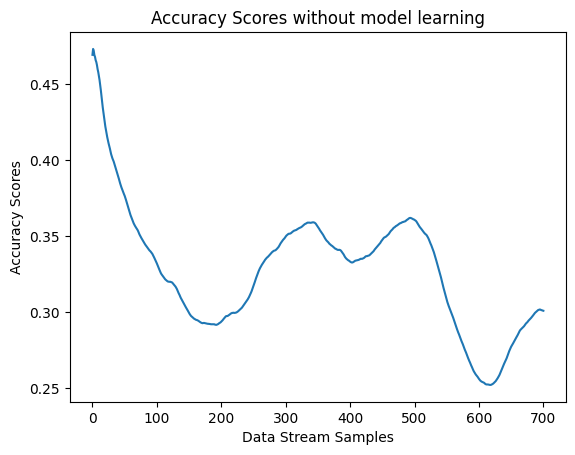

In [24]:
# Calculating moving average for accuracy score to remove noise
acc_scores_1_moving_avg = moving_average(acc_scores_1,100)
def plot():
    plt.plot(acc_scores_1_moving_avg)
    plt.xlabel('Data Stream Samples')
    plt.ylabel('Accuracy Scores')
    plt.title('Accuracy Scores without model learning')
    plt.show()
plot()

### Updating your models incrementally

#### River

In [25]:
# Initialiae dataset
dataset = synth.Agrawal(
     classification_function=0,
     seed=42
)

# Load saved model file
model_2 = pickle.load(open('saved_models/river_model.pkl', 'rb'))

# Initialize metrics and accuracy list
metric = metrics.Accuracy()
acc_scores_2 = list()

for i,data in enumerate(dataset.take(1000)):
    # data[0] - features, data[1] - label
    y_pred = model_2.predict_one(data[0])
    metric = metric.update(data[1],y_pred) # Accuracy
    accuracy_2 = update_error_window(y_pred,data[1])
    acc_scores_2.append(accuracy_2)
    model_2.learn_one(data[0], data[1])
print(metric)

Accuracy: 57.60%


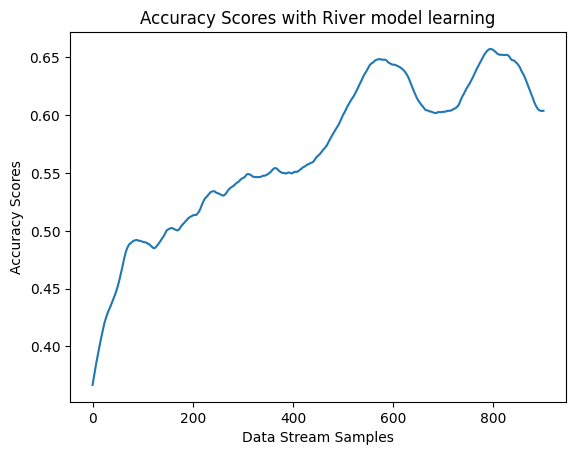

In [26]:
# Calculating moving average for accuracy score to remove noise
acc_scores_2_moving_avg = moving_average(acc_scores_2,100)
def plot():
    plt.plot(acc_scores_2_moving_avg)
    plt.xlabel('Data Stream Samples')
    plt.ylabel('Accuracy Scores')
    plt.title('Accuracy Scores with River model learning')
    plt.show()
plot()

#### Scikit-learn

In [27]:
import sklearn
from sklearn.linear_model import SGDClassifier

In [28]:
# Initialize Dataset
dataset = datasets.synth.Agrawal(
     classification_function=5,
     seed=42
)

# Load saved model file
sklrn_clf = pickle.load(open("saved_models/sklrn_model.pkl", 'rb'))

# Initialise metric
metric = metrics.Accuracy()
acc_scores_3 = list()

for i,data in enumerate(dataset.take(1000)):
    # data[0] - features, data[1] - label
    y_pred = sklrn_clf.predict(np.reshape(list(data[0].values()), (-1, 1)).T)
    metric = metric.update(data[1],y_pred[0])
    accuracy_3 = update_error_window(y_pred,data[1])
    acc_scores_3.append(accuracy_3)
    sklrn_clf.partial_fit(np.reshape(list(data[0].values()), (-1, 1)).T, np.array(data[1]).ravel())
print(metric)

Accuracy: 57.80%


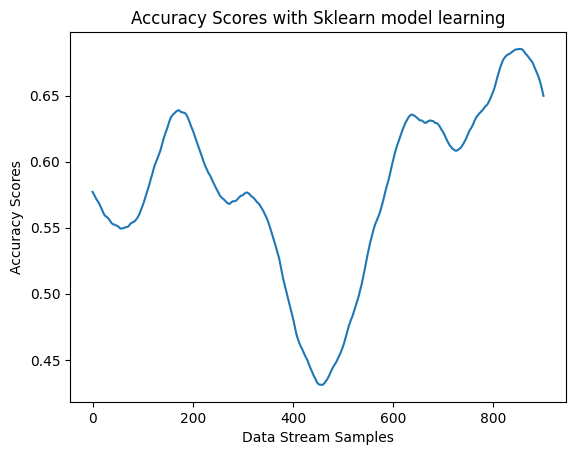

In [29]:
# Calculating moving average for accuracy score to remove noise
acc_scores_3_moving_avg = moving_average(acc_scores_3,100)
def plot():
    plt.plot(acc_scores_3_moving_avg)
    plt.xlabel('Data Stream Samples')
    plt.ylabel('Accuracy Scores')
    plt.title('Accuracy Scores with Sklearn model learning')
    plt.show()
plot()

#### PyTorch

https://github.com/online-ml/deep-river/tree/v0.1.2 (river_torch)

In [30]:
from river_torch import classification
from torch import nn
from torch import optim
from torch import manual_seed

In [31]:
_ = manual_seed(42)

In [32]:
class MyModule(nn.Module):
    def __init__(self, n_features):
        super(MyModule, self).__init__()
        self.dense0 = nn.Linear(n_features, 5)
        self.nonlin = nn.ReLU()
        self.dense1 = nn.Linear(5, 2)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.nonlin(self.dense1(X))
        X = self.softmax(X)
        return X

In [33]:
pyt_model = pickle.load(open("saved_models/pyt_river_model.pkl", 'rb'))

In [34]:
dataset = datasets.Phishing()
metric = metrics.Accuracy()
acc_scores_4 = list()

for x, y in dataset:
    y_pred = pyt_model.predict_one(x)  # make a prediction
    metric = metric.update(y, y_pred)  # update the metric
    model_pipeline = pyt_model.learn_one(x, y)  # make the model learn
    accuracy_4 = update_error_window(y_pred,y)
    acc_scores_4.append(accuracy_4)

print(metric)

Accuracy: 79.76%


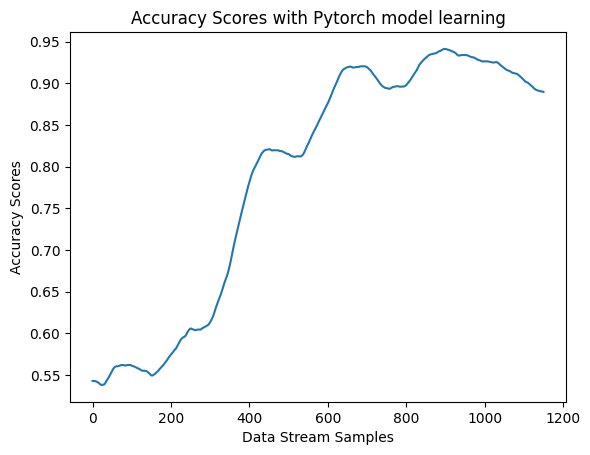

In [35]:
# Calculating moving average for accuracy score to remove noise
acc_scores_4_moving_avg = moving_average(acc_scores_4,100)
def plot():
    plt.plot(acc_scores_4_moving_avg)
    plt.xlabel('Data Stream Samples')
    plt.ylabel('Accuracy Scores')
    plt.title('Accuracy Scores with Pytorch model learning')
    plt.show()
plot()